In [74]:
import os
import string
from datetime import datetime, timedelta
import warnings
import pandas as pd
import numpy as np
from collections import Counter
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from dotenv import load_dotenv
from sqlalchemy import create_engine
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))
warnings.filterwarnings("ignore")



load_dotenv()
db_config = {
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'database': os.getenv('DB_NAME')
}

db_url = f"mysql+pymysql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(db_url)

news_data_query = ''' 
SELECT n.*, CASE WHEN request_id = 2 then 'index' else 'oil' end as request_category
FROM news_data n
'''

market_data_query = '''
SELECT m.*, CASE WHEN asset_name in ('WTI','BRENT') THEN 'oil' else 'index' END AS request_category
FROM market_data m
'''

with engine.connect() as connection:
    data = pd.read_sql(news_data_query,con=connection)
    market_data = pd.read_sql(market_data_query,con=connection)
    news_requests = pd.read_sql('select * from news_requests',con=connection)
# data['ticker'] = 'BZ=F'
data.head(2)

news_provider                               thread_uuid  \
0        webzio  0007ebb1827c54c22ce3e7e8d24ce45e664098bf   
1        webzio  002065a1387f99ad8392c70a934509172b12327c   

                                  post_uuid                site  \
0  0007ebb1827c54c22ce3e7e8d24ce45e664098bf  marketscreener.com   
1  002065a1387f99ad8392c70a934509172b12327c         latimes.com   

                                               title published_timestamp  \
0  Strathcona Resources : Announces Retirement of... 2024-10-25 01:53:00   
1  Orange County’s Fastest-Growing Public Compani... 2024-11-03 13:04:00   

  country  performance_score  domain_rank language sentiment  \
0      GB                  0         3951  english   neutral   
1      US                  0          204  english  positive   

                                        article_text  request_id  \
0  CALGARY, Alberta (October 24, 2024) - Strathco...           1   
1  Orange County’s Fastest-Growing Public Compani...           2   

  request_category  
0              oil  
1            index

In [97]:

tickers = ['CL=F', 'BZ=F', 'SPY', 'QQQ']
data['published_timestamp'] = pd.to_datetime(data['published_timestamp'], utc=True)
cutoff_time = pd.Timestamp('21:00:00').time()

# if published time after cutoff using next date
def determine_effective_date(row):
    published_time = row['published_timestamp'].time()
    published_date = row['published_timestamp'].date()
    if published_time <= cutoff_time:
        return published_date
    else:
        return published_date + timedelta(days=1)

data['effective_date'] = data.apply(determine_effective_date, axis=1)
market_data['business_date'] = pd.to_datetime(market_data['business_date']).dt.date

# date range
min_date = min(data['effective_date'].min(), market_data['business_date'].min())
max_date = max(data['effective_date'].max(), market_data['business_date'].max())
all_dates = pd.date_range(start=min_date, end=max_date).date

# full frame with all dates
all_combinations = pd.MultiIndex.from_product([tickers, all_dates], names=['ticker', 'business_date']).to_frame(index=False)
market_data_full = pd.merge(all_combinations, market_data, on=['ticker', 'business_date'], how='left')

# filling None
market_data_full = market_data_full.sort_values(['ticker', 'business_date']).reset_index(drop=True)
market_data_full['is_trading_day'] = market_data_full['close'].notna()
market_data_full.fillna(method='ffill', inplace=True)



# if effective date is not trading date then using next trading date
def get_next_trading_day(effective_date, request_category):
    ticker_data = market_data_full[market_data_full['request_category'] == request_category]
    trading_days = ticker_data[ticker_data['is_trading_day']]['business_date']
    future_trading_days = trading_days[trading_days >= effective_date]
    if not future_trading_days.empty:
        return future_trading_days.iloc[0]
    else:
        return None

def assign_business_date(row):
    effective_date = row['effective_date']
    request_category = row['request_category']
    is_trading_day = market_data_full[
        (market_data_full['request_category'] == request_category) &
        (market_data_full['business_date'] == effective_date)
    ]['is_trading_day'].values
    if is_trading_day.size > 0 and is_trading_day[0]:
        return effective_date
    else:
        next_trading_day = get_next_trading_day(effective_date, request_category)
        return next_trading_day

data['business_date'] = data.apply(assign_business_date, axis=1)


# same type
data['business_date'] = pd.to_datetime(data['business_date']).dt.date.astype(str)
market_data_full['business_date'] = pd.to_datetime(market_data_full['business_date']).dt.date.astype(str)

data_full = pd.merge(market_data_full, data, on=['request_category', 'business_date'], how='inner')
data_full.head()

ticker business_date       open       high        low      close  adj_close  \
0   BZ=F    2024-09-26  73.470001  73.769997  70.769997  71.599998  71.599998   
1   BZ=F    2024-09-26  73.470001  73.769997  70.769997  71.599998  71.599998   
2   BZ=F    2024-09-30  71.839996  73.099998  71.389999  71.769997  71.769997   
3   BZ=F    2024-09-30  71.839996  73.099998  71.389999  71.769997  71.769997   
4   BZ=F    2024-09-30  71.839996  73.099998  71.389999  71.769997  71.769997   

    volume asset_name    created_datetime  ...  \
0  18234.0      BRENT 2024-11-01 12:03:51  ...   
1  18234.0      BRENT 2024-11-01 12:03:51  ...   
2  41928.0      BRENT 2024-11-01 12:03:51  ...   
3  41928.0      BRENT 2024-11-01 12:03:51  ...   
4  41928.0      BRENT 2024-11-01 12:03:51  ...   

                                               title  \
0  ONEOK Third Quarter 2024 Conference Call and W...   
1  Analyst Comment: Reshoring\/Nearshoring is the...   
2                                    By: Ledger Live   
3  Brokerage calculator - Meaning, importance and...   
4                                                      

        published_timestamp country performance_score domain_rank language  \
0 2024-09-26 03:00:00+00:00      IR                 0      197175  english   
1 2024-09-26 00:25:00+00:00      US                 0       47922  english   
2 2024-09-29 05:42:00+00:00      US                 0      112263  english   
3 2024-09-28 11:43:00+00:00      IN                 0        3056  english   
4 2024-09-28 00:05:00+00:00      US                 0       16333  english   

  sentiment                                       article_text request_id  \
0   neutral  September 26, 2024 TULSA, Okla., Sept. 26, 202...          1   
1  positive  This comment is delivered by GlobalData Econom...          1   
2   neutral  Global markets witnessed a blend of caution an...          1   
3   neutral  <p>When you invest in stocks or trade in futur...          1   
4   neutral  Print Replica Bozeman Daily Chronicle\nManage ...          1   

   effective_date  
0      2024-09-26  
1      2024-09-26  
2      2024-09-29  
3      2024-09-28  
4      2024-09-28  

[5 rows x 26 columns]

In [137]:
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': -1,
    None: 0
}
data_full['sentiment_numeric'] = data_full['sentiment'].map(sentiment_mapping)
data_full['weight'] = 1 / data_full['domain_rank']

# making aggregated df
daily_sentiment = data_full.groupby(['ticker','asset_name','business_date', 'close'])['sentiment_numeric'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_numeric': 'avg_sentiment'}, inplace=True)

daily_sentiment.sort_values(['ticker','asset_name', 'business_date'], inplace=True)

# applying weight of domain_rank to sentiment_numeric
weighted_sentiment = data_full.groupby(['ticker','asset_name', 'business_date']).apply(
    lambda x: (x['sentiment_numeric'] * x['weight']).sum() / x['weight'].sum()
).reset_index(name='weighted_avg_sentiment')
daily_sentiment = daily_sentiment.merge(weighted_sentiment, on=['ticker','asset_name', 'business_date'], how='left')


for lag in [1, 2, 3, 7]:
    daily_sentiment[f'avg_sentiment_lag{lag}'] = daily_sentiment.groupby('ticker')['avg_sentiment'].shift(lag)
    daily_sentiment[f'weighted_avg_sentiment_lag{lag}'] = daily_sentiment.groupby('ticker')['weighted_avg_sentiment'].shift(lag)
    daily_sentiment[f'avg_sentiment_diff{lag}'] = daily_sentiment['avg_sentiment'] - daily_sentiment[f'avg_sentiment_lag{lag}']
    daily_sentiment[f'weighted_avg_sentiment_diff{lag}'] = daily_sentiment['weighted_avg_sentiment'] - daily_sentiment[f'weighted_avg_sentiment_lag{lag}']
    
# sentiment_acceleration
daily_sentiment['sentiment_acceleration'] = daily_sentiment['avg_sentiment_diff1'] - daily_sentiment.groupby('ticker')['avg_sentiment_diff1'].shift(1)
daily_sentiment['weighted_sentiment_acceleration'] = daily_sentiment['weighted_avg_sentiment_diff1'] - daily_sentiment.groupby('ticker')['weighted_avg_sentiment_diff1'].shift(1)

# std
sentiment_std = data_full.groupby(['ticker','asset_name', 'business_date'])['sentiment_numeric'].std().reset_index(name='sentiment_std')
daily_sentiment = daily_sentiment.merge(sentiment_std, on=['ticker','asset_name', 'business_date'], how='left')

# rolling average
for window in [7, 15, 30]:
    daily_sentiment[f'avg_sentiment_ma_{window}'] = daily_sentiment.groupby('ticker')['avg_sentiment'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    daily_sentiment[f'weighted_avg_sentiment_ma_{window}'] = daily_sentiment.groupby('ticker')['weighted_avg_sentiment'].transform(lambda x: x.rolling(window, min_periods=1).mean())


# how price changed
daily_sentiment.sort_values(['ticker','asset_name', 'business_date'], inplace=True)
daily_sentiment['price_change'] = daily_sentiment.groupby('ticker')['close'].diff()

In [154]:
daily_sentiment

ticker asset_name business_date       close  avg_sentiment  \
0    BZ=F      BRENT    2024-09-26   71.599998       0.500000   
1    BZ=F      BRENT    2024-09-30   71.769997       0.000000   
2    BZ=F      BRENT    2024-10-01   73.559998      -0.166667   
3    BZ=F      BRENT    2024-10-03   77.620003       0.500000   
4    BZ=F      BRENT    2024-10-04   78.050003       0.333333   
..    ...        ...           ...         ...            ...   
85    SPY    S&P 500    2024-10-25  579.039978       0.115385   
86    SPY    S&P 500    2024-10-28  580.830017       0.166667   
87    SPY    S&P 500    2024-10-29  581.770020       0.285714   
88    SPY    S&P 500    2024-10-30  580.010010       0.032258   
89    SPY    S&P 500    2024-10-31  568.640015       0.060958   

    weighted_avg_sentiment  avg_sentiment_lag1  weighted_avg_sentiment_lag1  \
0                 0.804477                 NaN                          NaN   
1                 0.000000            0.500000                     0.804477   
2                -0.610865            0.000000                     0.000000   
3                 0.530312           -0.166667                    -0.610865   
4                 0.358608            0.500000                     0.530312   
..                     ...                 ...                          ...   
85                0.231434            0.222222                     0.089875   
86                0.612334            0.115385                     0.231434   
87                0.580929            0.166667                     0.612334   
88                0.524159            0.285714                     0.580929   
89                0.045768            0.032258                     0.524159   

    avg_sentiment_diff1  weighted_avg_sentiment_diff1  ...  \
0                   NaN                           NaN  ...   
1             -0.500000                     -0.804477  ...   
2             -0.166667                     -0.610865  ...   
3              0.666667                      1.141177  ...   
4             -0.166667                     -0.171704  ...   
..                  ...                           ...  ...   
85            -0.106838                      0.141559  ...   
86             0.051282                      0.380900  ...   
87             0.119048                     -0.031405  ...   
88            -0.253456                     -0.056770  ...   
89             0.028700                     -0.478391  ...   

    sentiment_acceleration  weighted_sentiment_acceleration  sentiment_std  \
0                      NaN                              NaN       0.707107   
1                      NaN                              NaN       0.000000   
2                 0.333333                         0.193612       0.752773   
3                 0.833333                         1.752042       0.707107   
4                -0.833333                        -1.312880       0.577350   
..                     ...                              ...            ...   
85                0.004274                         0.191467       0.515901   
86                0.158120                         0.239341       0.707107   
87                0.067766                        -0.412305       0.611250   
88               -0.372504                        -0.025365       0.481932   
89                0.282156                        -0.421621       0.666298   

    avg_sentiment_ma_7  weighted_avg_sentiment_ma_7  avg_sentiment_ma_15  \
0             0.500000                     0.804477             0.500000   
1             0.250000                     0.402239             0.250000   
2             0.111111                     0.064537             0.111111   
3             0.208333                     0.180981             0.208333   
4             0.233333                     0.216506             0.233333   
..                 ...                          ...                  ...   
85            0.127595                     0.100266        

In [193]:
target_assets = ['Nasdaq-100', 'S&P 500']
print(f'Correlation table for {target_assets[0]} and {target_assets[1]}')
daily_sentiment.loc[daily_sentiment.asset_name.isin(target_assets)].select_dtypes(['float','int'])\
               .corr()[['close','price_change']]\
               .reset_index()\
               .rename(columns={'index':'feature'})\
               .sort_values('price_change')

Correlation table for Nasdaq-100 and S&P 500


feature     close  price_change
8       weighted_avg_sentiment_lag2 -0.029696     -0.412917
12      weighted_avg_sentiment_lag3 -0.052548     -0.389281
21                    sentiment_std -0.004660     -0.389169
19           sentiment_acceleration -0.023722     -0.324402
5               avg_sentiment_diff1 -0.001305     -0.315913
7                avg_sentiment_lag2 -0.025994     -0.252730
1                     avg_sentiment -0.019257     -0.222189
23      weighted_avg_sentiment_ma_7 -0.063766     -0.198147
11               avg_sentiment_lag3 -0.033952     -0.162736
25     weighted_avg_sentiment_ma_15 -0.080281     -0.141356
20  weighted_sentiment_acceleration -0.013094     -0.140181
2            weighted_avg_sentiment  0.003107     -0.124418
22               avg_sentiment_ma_7 -0.066422     -0.096248
6      weighted_avg_sentiment_diff1  0.019625     -0.076262
24              avg_sentiment_ma_15 -0.085912     -0.069516
4       weighted_avg_sentiment_lag1 -0.001793     -0.028824
27     weighted_avg_sentiment_ma_30 -0.077310     -0.010553
13              avg_sentiment_diff3  0.034054     -0.009836
17              avg_sentiment_diff7  0.001551      0.001252
15               avg_sentiment_lag7 -0.004222      0.010442
16      weighted_avg_sentiment_lag7 -0.000761      0.011776
9               avg_sentiment_diff2  0.017346      0.030213
0                             close  1.000000      0.039958
26              avg_sentiment_ma_30 -0.081032      0.042545
18     weighted_avg_sentiment_diff7  0.011452      0.076065
3                avg_sentiment_lag1  0.000539      0.192885
14     weighted_avg_sentiment_diff3  0.056202      0.199893
10     weighted_avg_sentiment_diff2  0.038402      0.230584
28                     price_change  0.039958      1.000000

In [194]:
target_assets = ['BRENT', 'WTI']
print(f'Correlation table for {target_assets[0]} and {target_assets[1]}')
daily_sentiment.loc[daily_sentiment.asset_name.isin(target_assets)].select_dtypes(['float','int'])\
               .corr()[['close','price_change']]\
               .reset_index()\
               .rename(columns={'index':'feature'})\
               .sort_values('price_change')

Correlation table for BRENT and WTI


feature     close  price_change
10     weighted_avg_sentiment_diff2  0.046778     -0.235220
15               avg_sentiment_lag7  0.175358     -0.223384
2            weighted_avg_sentiment -0.121304     -0.199128
16      weighted_avg_sentiment_lag7  0.085236     -0.170076
4       weighted_avg_sentiment_lag1 -0.192681     -0.100792
12      weighted_avg_sentiment_lag3 -0.124045     -0.058302
14     weighted_avg_sentiment_diff3  0.054796     -0.055721
6      weighted_avg_sentiment_diff1  0.115901     -0.052948
9               avg_sentiment_diff2  0.016678     -0.042290
11               avg_sentiment_lag3 -0.070721     -0.023169
5               avg_sentiment_diff1  0.057649     -0.021449
19           sentiment_acceleration -0.039932      0.015960
18     weighted_avg_sentiment_diff7 -0.100323      0.022560
1                     avg_sentiment -0.126684      0.033593
3                avg_sentiment_lag1 -0.097547      0.058195
13              avg_sentiment_diff3  0.023091      0.067922
20  weighted_sentiment_acceleration  0.037508      0.088655
21                    sentiment_std  0.023725      0.093430
7                avg_sentiment_lag2 -0.046802      0.093840
17              avg_sentiment_diff7 -0.200048      0.102126
25     weighted_avg_sentiment_ma_15 -0.174169      0.125718
27     weighted_avg_sentiment_ma_30 -0.199936      0.143256
8       weighted_avg_sentiment_lag2 -0.086263      0.172080
23      weighted_avg_sentiment_ma_7 -0.192797      0.210486
24              avg_sentiment_ma_15 -0.010395      0.249756
26              avg_sentiment_ma_30 -0.059365      0.270072
0                             close  1.000000      0.281063
22               avg_sentiment_ma_7 -0.065233      0.337323
28                     price_change  0.281063      1.000000

#### Фонды
1. В случае с фондами наиболее сильная отрицательная связь с изменением цены наблюдается у признаков weighted_avg_sentiment_lag2 (-0.41), weighted_avg_sentiment_lag3(-0.38) и sentiment_std (-0.38).
В нашем случае это может указывать на то, что высокий сентимент на ранних стадиях предшествуют стабилизации или снижению ценовых изменений, а его низкая вариативность может указывать на стабильные настроения, что также связано с низкими изменениями цены.
2. Большая часть признаков сентимента негативно коррелирует с изменением цены. Это может свидетельствовать о том, что положительный сентимент имеет меньшее влияние на изменение цены.

#### Нефть
1. Самая сильная положительная корреляция наблюдается у признаков скользящего среднего для сентимент. Это указывает на то, что более высокий средний сентимент за последние 7, 15 и 30 дней связан с увеличением цен на BRENT и WTI. Это свидетельствует о том, что позитивная повестка в тематически связанных новостях связана с ростом  цен на нефть.
2. При этом мы видим негативную корреляцию с изменением цены у признаков, полученных с взвешиванием через ранг источника. Для нас это может свидетельствовать о том, что влияние самых высокоранговых источников может расходиться с общей повесткой или о том, что новости в этих источниках могли быть менее релевантны по отношению к исследуемым активам.

## Далее на графиках представлено как проявляется изменение цены относительно скользящего среднего сентимента для нефти и относительно разницы в сентиментах для индексов

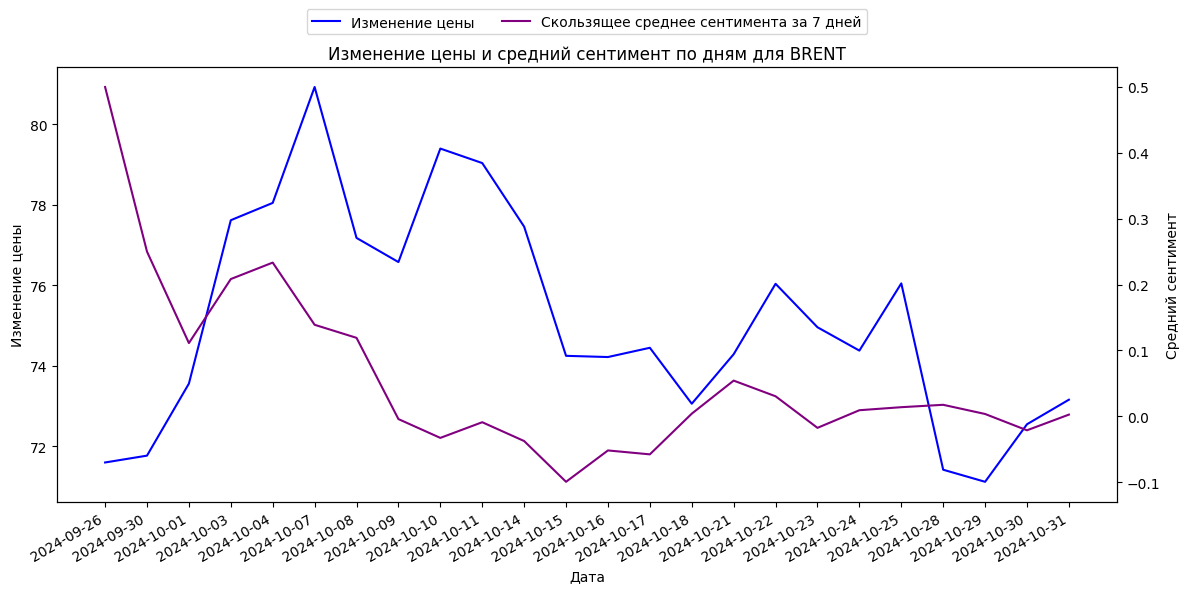

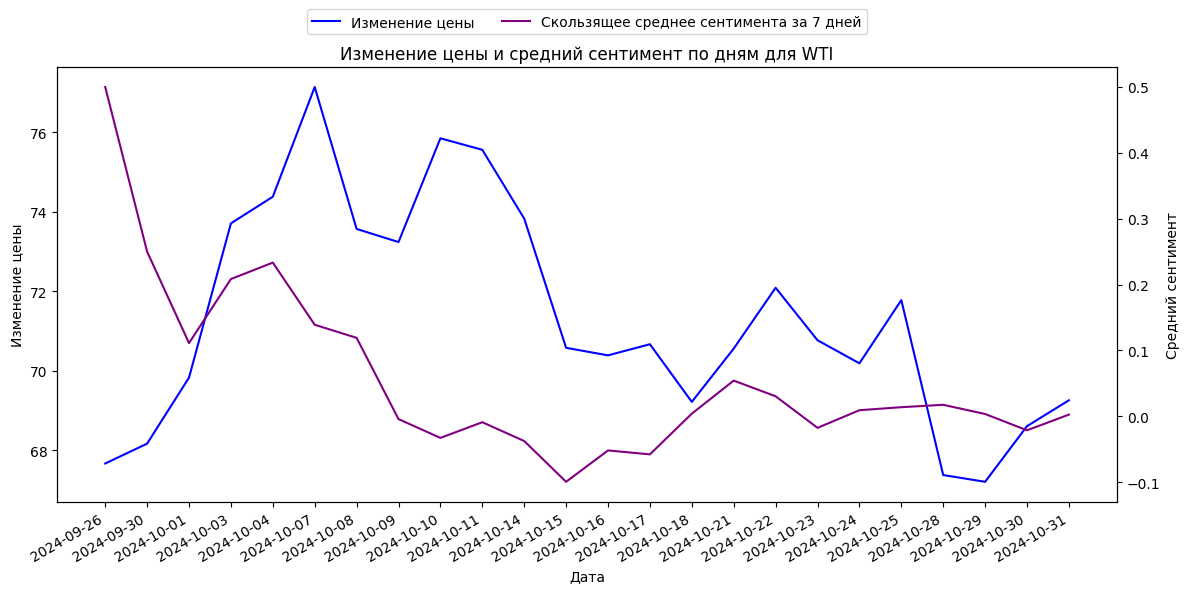

In [199]:
import matplotlib.pyplot as plt

for asset_name in ['BRENT', 'WTI']:
    temp = daily_sentiment.loc[daily_sentiment.asset_name == asset_name]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # График изменения цены на первичной оси Y
    ax1.plot(temp['business_date'], temp['close'], color='blue', label='Изменение цены')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Изменение цены')
    ax1.tick_params(axis='y')

    # Создаем вторичную ось Y
    ax2 = ax1.twinx()

    # График взвешенного среднего сентимента
#     ax2.plot(temp['business_date'], temp['weighted_avg_sentiment'], color='red', label='Взвешенный скользящий сентимент')
    # График среднего сентимента
    ax2.plot(temp['business_date'], temp['avg_sentiment_ma_7'], color='purple', label='Скользящее среднее сентимента за 7 дней')
    ax2.set_ylabel('Средний сентимент')
    ax2.tick_params(axis='y')

    # Объединяем легенды
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    # Устанавливаем заголовок
    plt.title(f'Изменение цены и средний сентимент по дням для {asset_name}')

    # Форматируем даты на оси X
    fig.autofmt_xdate()

    # Отображаем график
    plt.tight_layout()
    plt.show()

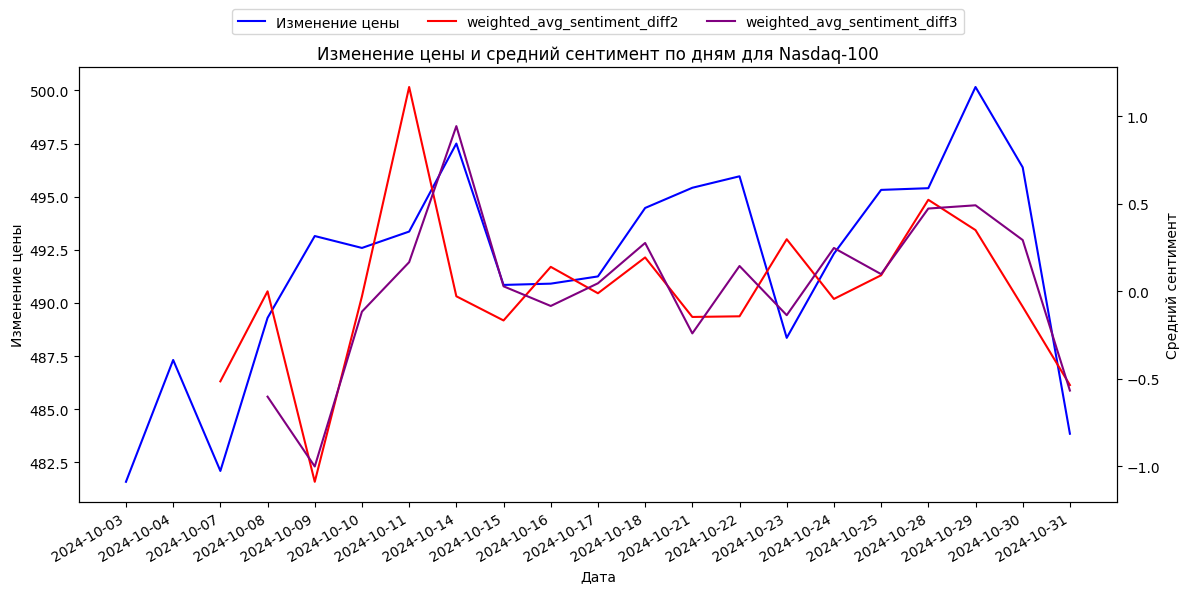

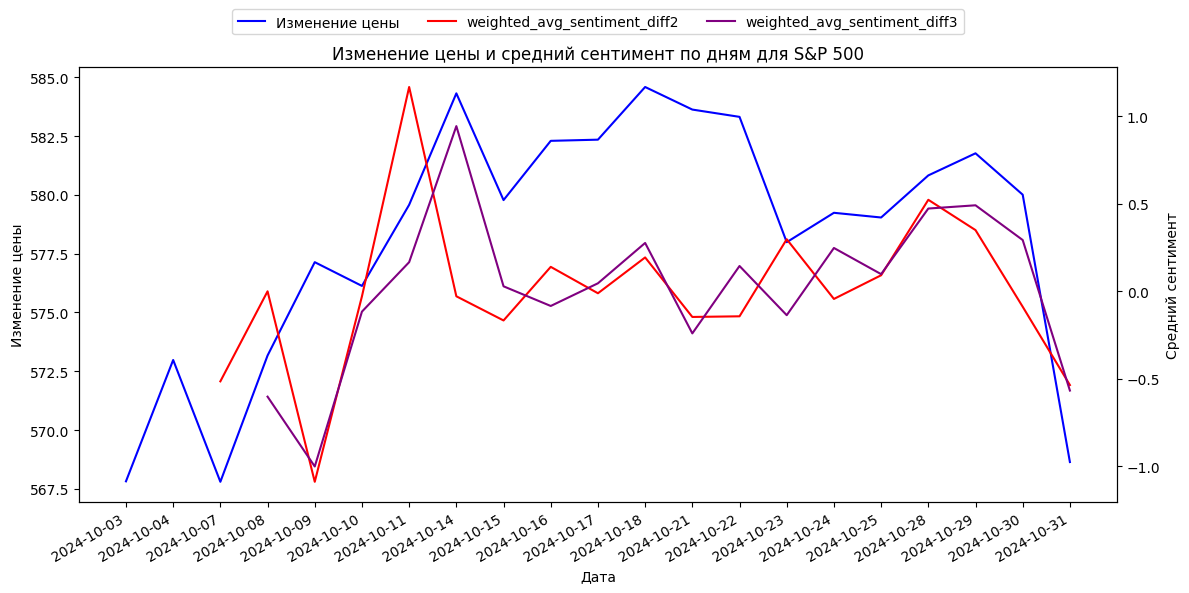

In [200]:
import matplotlib.pyplot as plt

for asset_name in ['Nasdaq-100', 'S&P 500']:
    temp = daily_sentiment.loc[daily_sentiment.asset_name == asset_name]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # График изменения цены на первичной оси Y
    ax1.plot(temp['business_date'], temp['close'], color='blue', label='Изменение цены')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Изменение цены')
    ax1.tick_params(axis='y')

    # Создаем вторичную ось Y
    ax2 = ax1.twinx()

    # График взвешенного среднего сентимента
    ax2.plot(temp['business_date'], temp['weighted_avg_sentiment_diff2'], color='red', label='weighted_avg_sentiment_diff2')
    # График среднего сентимента
    ax2.plot(temp['business_date'], temp['weighted_avg_sentiment_diff3'], color='purple', label='weighted_avg_sentiment_diff3')
    ax2.set_ylabel('Средний сентимент')
    ax2.tick_params(axis='y')

    # Объединяем легенды
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    # Устанавливаем заголовок
    plt.title(f'Изменение цены и средний сентимент по дням для {asset_name}')

    # Форматируем даты на оси X
    fig.autofmt_xdate()

    # Отображаем график
    plt.tight_layout()
    plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

In [ ]:
daily_sentiment

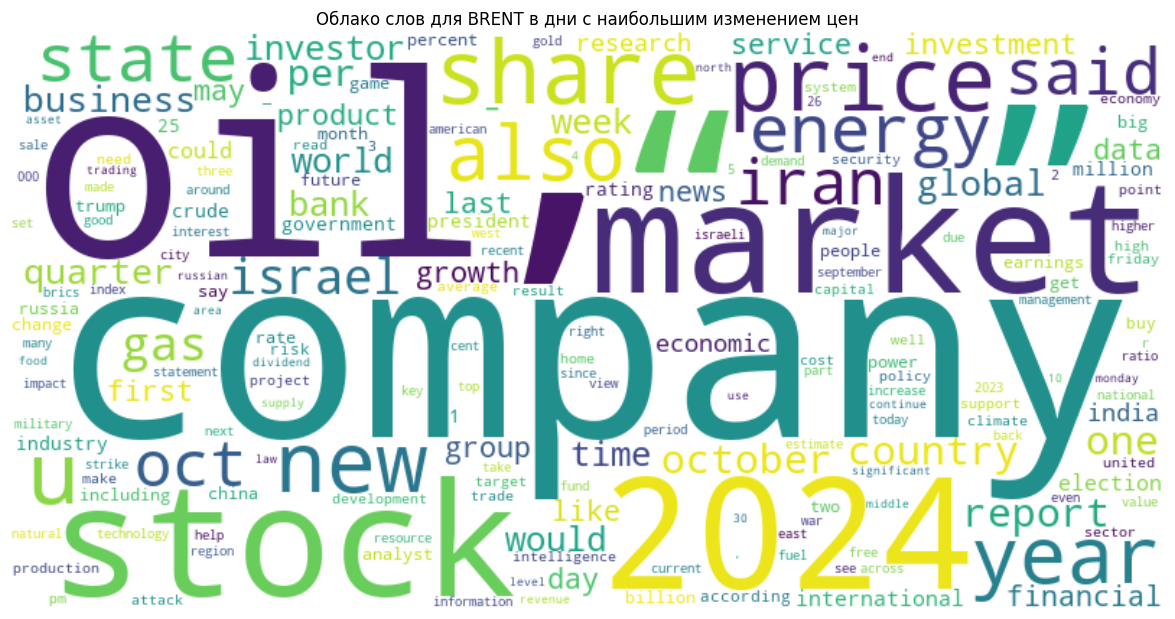

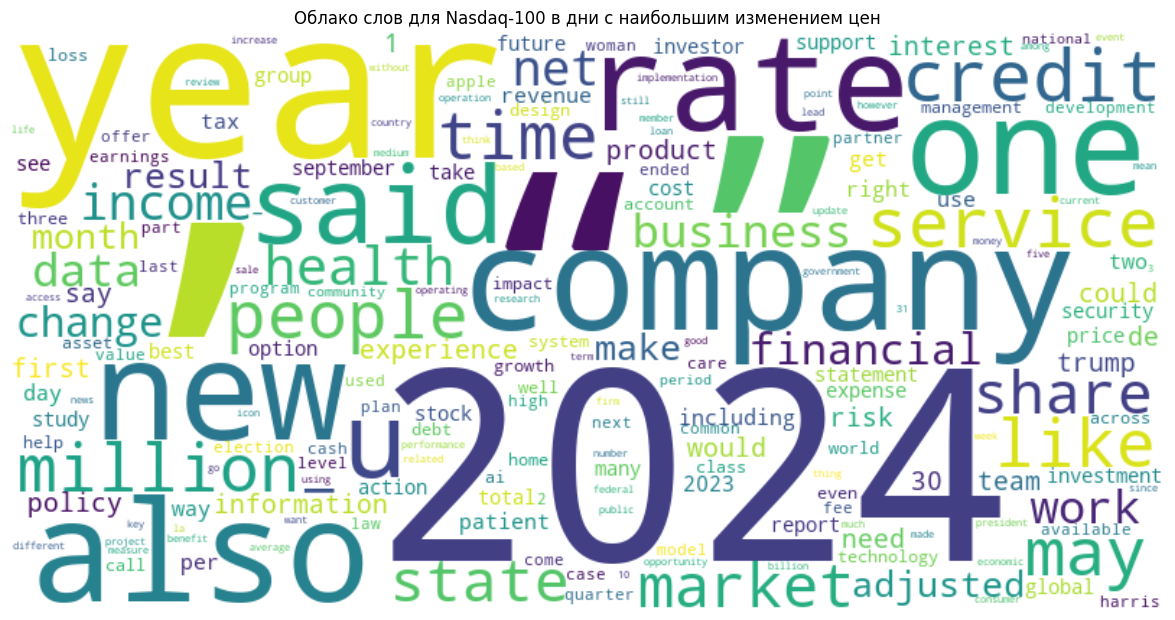

In [236]:
daily_sentiment['business_date'] = pd.to_datetime(daily_sentiment['business_date'])

# price changing
daily_sentiment.sort_values(['ticker', 'business_date'], inplace=True)
daily_sentiment['price_change'] = daily_sentiment.groupby('ticker')['close'].diff()
daily_sentiment['abs_price_change'] = daily_sentiment['price_change'].abs()

# top 5
tokens_list = dict()
for asset_name in ['BRENT', 'Nasdaq-100']:
    top_days = daily_sentiment[daily_sentiment['asset_name'] == asset_name].sort_values('abs_price_change',ascending=False).iloc[:5]

    selected_dates = top_days['business_date'].dt.date.unique()
    filtered_data = data_full[
        (data_full['asset_name'] == asset_name) &
        (pd.to_datetime(data_full['business_date']).dt.date.isin(selected_dates))
    ]
    text_data = ' '.join(filtered_data['article_text'].astype(str))

    # text preprocessor
    text_data = text_data.lower()
    text_data = text_data.translate(str.maketrans('', '', string.punctuation))

    tokens = nltk.word_tokenize(text_data)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    word_counts = Counter(tokens)
    tokens_list[asset_name] = word_counts
    
    # WordCloud creation
    processed_text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1.0).generate_from_frequencies(word_counts)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов для {asset_name} в дни с наибольшим изменением цен')
    plt.show()

In [242]:
print('Топ 25 слов, встречаемых в даты с самым сильным изменением цены на фонды ')
word_counts = tokens_list['Nasdaq-100']
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
word_counts_df = word_counts_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
word_counts_df.head(25)

Топ 25 слов, встречаемых в даты с самым сильным изменением цены на фонды 


word  frequency
0         ’       6396
1         “       2347
2         ”       2291
3      2024       1604
4      year       1429
5   company       1374
6      also       1283
7       new       1254
8      rate       1148
9       one       1144
10     said       1077
11        u       1057
12   credit        980
13  service        966
14      may        933
15  million        932
16   people        918
17     like        903
18     time        884
19   market        848
20    state        815
21    share        808
22   health        799
23   income        798
24        —        786

In [243]:
print('Топ 25 слов, встречаемых в даты с самым сильным изменением цены на нефть ')
word_counts = tokens_list['BRENT']
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
word_counts_df = word_counts_df.sort_values(by='frequency', ascending=False).reset_index(drop=True)
word_counts_df.head(25)

Топ 25 слов, встречаемых в даты с самым сильным изменением цены на нефть 


word  frequency
0         ’      17009
1   company       6628
2       oil       6522
3         “       6392
4         ”       6272
5    market       6168
6     stock       6121
7      2024       6044
8     price       5470
9     share       5257
10        u       5127
11      new       4864
12     year       4291
13     also       3864
14   energy       3793
15    state       3727
16     said       3465
17      oct       3299
18     iran       3256
19   israel       3182
20      gas       3084
21   report       3015
22  october       2926
23      one       2853
24  country       2843

### Оба набора данных содержат информацию связанную с корпоративными новостями и ценовыми изменениями (market,share,stock).

Однако набор новостей связанных с нефтью содержит больший акцент на геополитике и энергетике (oil, energy, gas, iran, israel).

В то время как новости связанные с индексами включают в себя больше слов с экономическими темами (credit,service,income,rate)

In [101]:
# alternative plot 
for ticker in daily_sentiment.ticker.unique():
    temp = daily_sentiment.loc[daily_sentiment.ticker==ticker]

    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=temp['business_date'],
            y=temp['close'],
            name='Изменение цены',
            yaxis='y1',
            line=dict(color='blue')
        )
    )
    fig.add_trace(
        go.Scatter(
            x=temp['business_date'],
            y=temp['weighted_avg_sentiment'],
            name='Взвешенный средний сентимент',
            yaxis='y2',
            line=dict(color='red')
        )
    )
    fig.add_trace(
        go.Scatter(
            x=temp['business_date'],
            y=temp['avg_sentiment'],
            name='Средний сентимент',
            yaxis='y2',
            line=dict(color='purple')
        )
    )
    fig.update_layout(
        title=f'Изменение цены и средний сентимент по дням для {ticker}',
        xaxis_title='Дата',
        template='plotly_white',
        yaxis=dict(
            title='Изменение цены',
        ),
        yaxis2=dict(
            title='Средний сентимент',
            overlaying='y',
            side='right',
        ),
        legend=dict(
            x=0,
            y=1.1,
            orientation='h'
        )
    )
    fig.show()

In [135]:

fig = go.Figure()
for asset_name in market_data_full.asset_name.unique():
    temp = market_data_full.loc[market_data_full.asset_name==asset_name]
    
    fig.add_trace(
        go.Scatter(
            x=temp['business_date'],
            y=temp['close'],
            name=asset_name,
        )
    )
fig.show()